# Create Embeddings from the data you provide using Geneformer model

In [12]:
#importing the needed packages
import scanpy as sc
import os
from geneformer import TranscriptomeTokenizer, EmbExtractor, DataCollatorForCellClassification
import datasets
import json
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import pickle
import numpy as np

## Read and process data 
### create ensemble and n counts, for gene and cells 
### create join_id for geneformer to make predictions

In [3]:
adata = sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/dataset_20_20.h5ad")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

h5ad_dir = "/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/h5ad/"

if not os.path.exists(h5ad_dir):
    os.makedirs(h5ad_dir)
# write the changed data into an h5ad file
adata.write(h5ad_dir + "m_f_2_2.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 114718 × 33105
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', '

# Use the Tokenizer from geneformer to tokenize the data and store it using huggingface dataset.arrow format

In [5]:
# directory to store the tokeized data
token_dir = "/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/tokenized_data/"

if not os.path.exists(token_dir):
    os.makedirs(token_dir)
# As its using the 30m model I have given path of the 30m model gene_median_dict,token_dict and gene_mapping_dict
tk = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid"},
                            model_input_size = 2048,
                            special_token = False,
                            collapse_gene_ids=True,
                            gene_median_file="/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl" ,
                            token_dictionary_file= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl",
                            gene_mapping_file= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl")
tk.tokenize_data(data_directory=h5ad_dir,
                 output_directory=token_dir, 
                 output_prefix="m_f_2_2", 
                 file_format="h5ad")

/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenizing /hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/h5ad/m_f_20_20.h5ad


/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/h5ad/m_f_20_20.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Tokenizing /hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/h5ad/m_f_2_2.h5ad


/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/h5ad/m_f_2_2.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [13]:
#Load the model and mapping dictionary of the classification layer which maps labels to cells
model_dir = "/hpcfs/users/a1841503/Geneformer/fine_tuned_geneformer"
label_mapping_dict_file = os.path.join(model_dir, "label_to_cell_subclass.json")

with open(label_mapping_dict_file) as fp:
    label_mapping_dict = json.load(fp)

with open('/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl','rb') as f:
    token_dict=pickle.load(f)

In [10]:
#load the tokenized data
token_dir = "/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/tokenized_data/"
dataset = datasets.load_from_disk(token_dir + "m_f_20_20.dataset")
dataset

Dataset({
    features: ['input_ids', 'joinid', 'length'],
    num_rows: 114718
})

###  Add a dummy column named "label" needed for Geneformer to make predictions.

In [11]:
dataset = dataset.add_column("label", [0] * len(dataset))
dataset

Dataset({
    features: ['input_ids', 'joinid', 'length', 'label'],
    num_rows: 114718
})

## Inferencing the model that means to forward pass the new data and extract the embedding from the last layer

### Inferencing the model

In [14]:
# load pretrained model
model = BertForSequenceClassification.from_pretrained(model_dir)
# create the trainer
trainer = Trainer(model=model, data_collator=DataCollatorForCellClassification(token_dictionary=token_dict))
# use trainer to predict
predictions = trainer.predict(dataset)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [15]:
#Getting the predictions probabilities from the model and calculating the predictions fromt he labels
predicted_label_ids = np.argmax(predictions.predictions, axis=1)
predicted_logits = [predictions.predictions[i][predicted_label_ids[i]] for i in range(len(predicted_label_ids))]
predicted_labels = [label_mapping_dict[str(i)] for i in predicted_label_ids]

In [16]:
#creating another ann data to not mix up the two and attaching the predictions to it
adata_inference=adata.copy()
adata_inference.obs["predicted_cell_subclass"] = predicted_labels
adata_inference.obs["predicted_cell_subclass_probability"] = np.exp(predicted_logits) / (1 + np.exp(predicted_logits))

In [17]:
(adata,adata_inference)

(AnnData object with n_obs × n_vars = 114718 × 33105
     obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler',

## Preprocessing the data to visualize

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/mnt/tmp_local/lls_3503640/ipykernel_3352392/4225556739.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


AnnData object with n_obs × n_vars = 114718 × 1009
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'c

## Extracting the embeddings

In [19]:
n_classes = len(label_mapping_dict)
embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=n_classes,
    emb_mode="cell",
    max_ncells=None,
    emb_label=["joinid"],
    emb_layer=0,
    forward_batch_size=30,
    nproc=8,
)

In [20]:
#creating an output directory to store the embedding in a csv
output_dir = "/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/geneformer_embeddings/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
emb_inference = embex.extract_embs(
    model_directory=model_dir,
    input_data_file=token_dir + "m_f_20_20.dataset",
    output_directory=output_dir,
    output_prefix="emb_inference",
)

CLS token present in token dictionary, excluding from average.
EOS token present in token dictionary, excluding from average.
100%|██████████| 3824/3824 [12:51<00:00,  4.96it/s]


In [21]:
# Sorting the embedding accoring to the join_id to match the data and attaching it to the data
emb_inference= emb_inference.sort_values("joinid")
adata_inference.obsm["geneformer_inference"] = emb_inference.drop(columns="joinid").to_numpy()

# Calculating the UMAP
sc.pp.neighbors(adata_inference, n_neighbors=10, n_pcs=40, use_rep="geneformer_inference")
sc.tl.umap(adata_inference)

## Comparing the data to the embeddings with UMAP

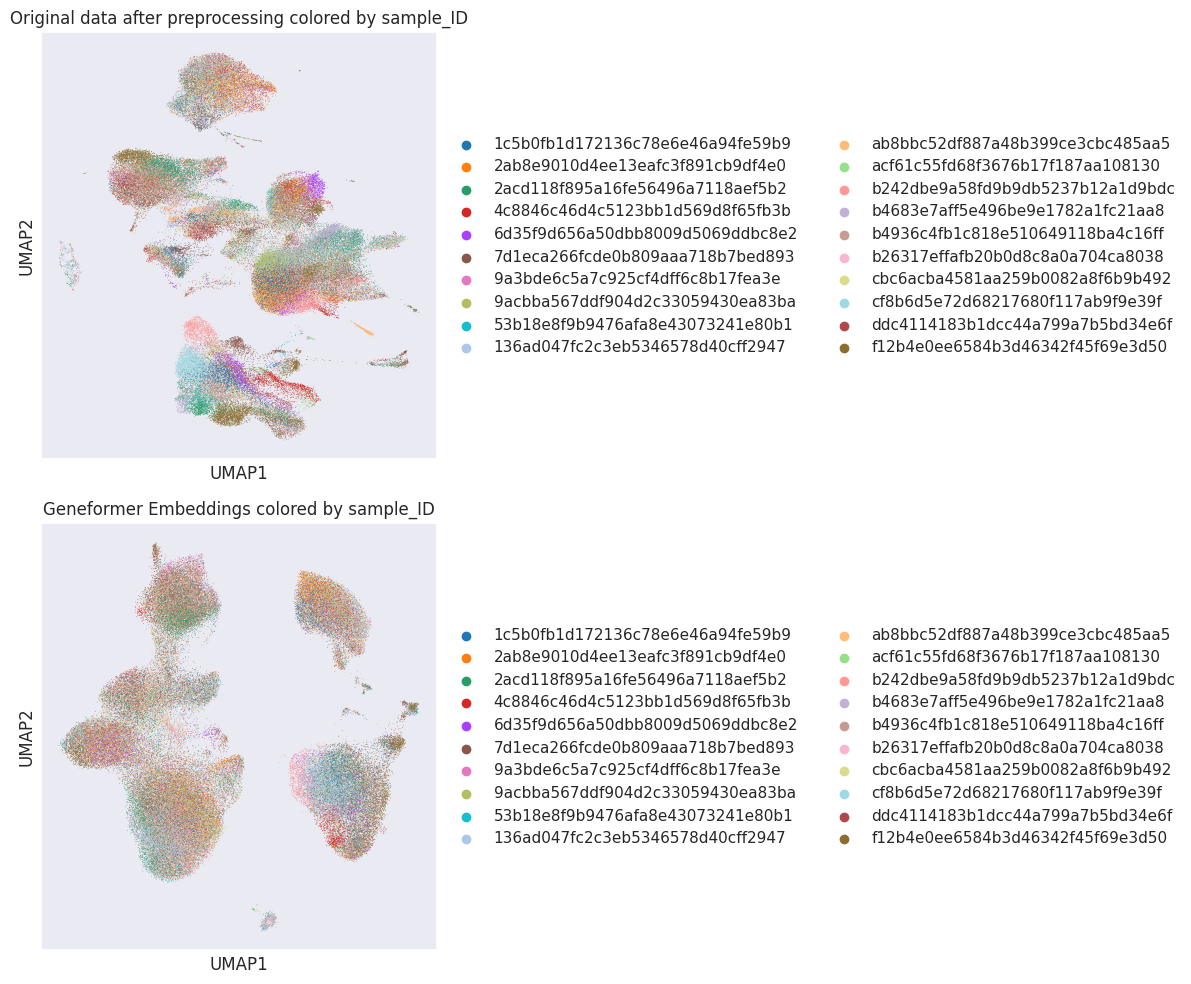

In [23]:
# Setup fig size and its orientation
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# First row
sc.pl.umap(adata, color="sample_id", show=False, ax=axes[0], 
           title="Original data after preprocessing colored by sample_ID")

# Second ro
sc.pl.umap(adata_inference, color="sample_id", show=False, ax=axes[1], 
           title="Geneformer Embeddings colored by sample_ID")

# Adjust layout
plt.tight_layout()
plt.show()

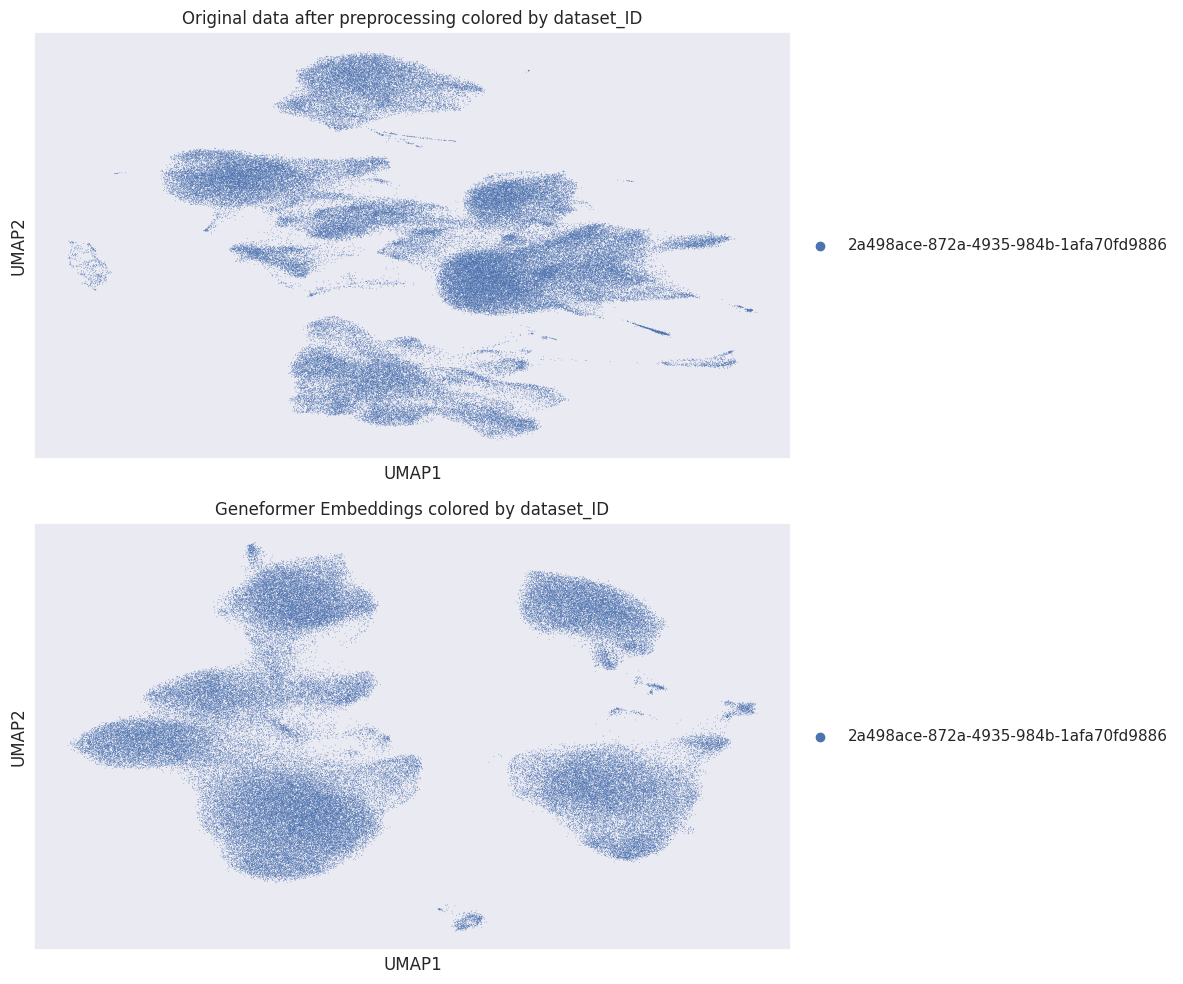

In [24]:
# Setup fig size and its orientation
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# First row
sc.pl.umap(adata, color="dataset_id", show=False, ax=axes[0], 
           title="Original data after preprocessing colored by dataset_ID")

# Second row
sc.pl.umap(adata_inference, color="dataset_id", show=False, ax=axes[1], 
           title="Geneformer Embeddings colored by dataset_ID")

# Adjust layout
plt.tight_layout()
plt.show()

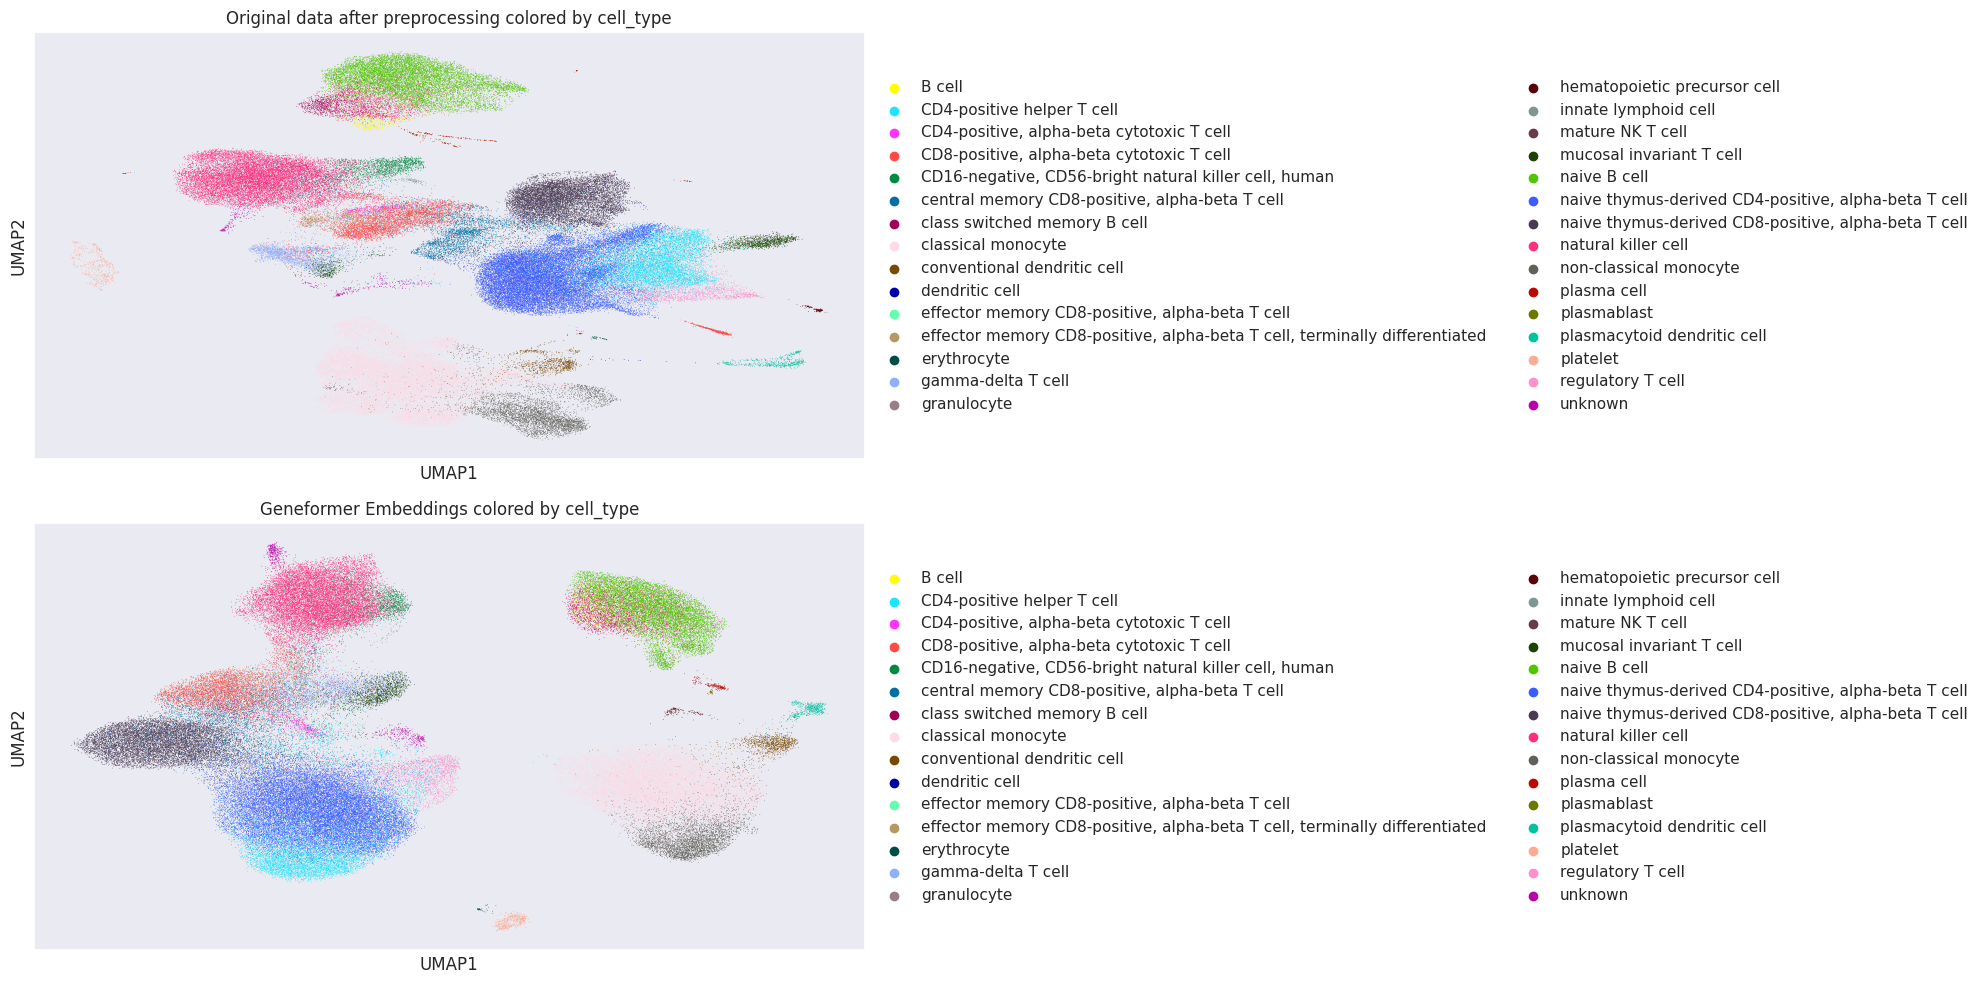

In [26]:
# Setup fig size and its orientation
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# First row
sc.pl.umap(adata, color="cell_type", show=False, ax=axes[0], 
           title="Original data after preprocessing colored by cell_type")

# Second row
sc.pl.umap(adata_inference, color="cell_type", show=False, ax=axes[1], 
           title="Geneformer Embeddings colored by cell_type")

# Adjust layout
plt.tight_layout()
plt.show()

## Save the anndata in h5ad

In [31]:
adata_inference.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellxgene_version_long/data/h5ad/geneformer_embeddings.h5ad")